# Exploratory notebook 
The goal of this notebook is to conduct the research part of "predicting the results of a match". Importing data from past seasons, transforming that data to extract new indicators (prétraitement et EDA), developping and evaluating models.

## Load packages and transform data

In [109]:

import pandas as pd             # manipulation de données tabulaires
import sys
import os
import json                     # pour afficher proprement le JSON si besoin
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.path.abspath(".."))


In [77]:
from src.etl import fetch_matches, save_raw_matches, load_raw_matches

In [78]:
#matches_json=fetch_matches(2015,2024) #Ligue 1 saison 2024-2025

#save_raw_matches(matches_json,"../data/raw/")

matches_json=load_raw_matches("../data/raw/",season_id=2024)

In [79]:
matches_list = matches_json["matches"]
df_matches = pd.json_normalize(matches_list)

In [80]:
df_matches.head()

,id,utcDate,status,matchday,stage,group,lastUpdated,referees,area.id,area.name,...,awayTeam.shortName,awayTeam.tla,awayTeam.crest,score.winner,score.duration,score.fullTime.home,score.fullTime.away,score.halfTime.home,score.halfTime.away,odds.msg
0,497958,2024-08-16T18:45:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57042, 'name': 'Willy Delajod', 'type'...",2081,France,...,PSG,PSG,https://crests.football-data.org/524.png,AWAY_TEAM,REGULAR,1,4,0,1,Activate Odds-Package in User-Panel to retriev...
1,497951,2024-08-17T15:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 43926, 'name': 'Benoît Bastien', 'type...",2081,France,...,Marseille,MAR,https://crests.football-data.org/516.png,AWAY_TEAM,REGULAR,1,5,1,3,Activate Odds-Package in User-Panel to retriev...
2,497956,2024-08-17T17:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57092, 'name': 'Eric Wattellier', 'typ...",2081,France,...,Lille,LIL,https://crests.football-data.org/521.png,AWAY_TEAM,REGULAR,0,2,0,1,Activate Odds-Package in User-Panel to retriev...
3,497955,2024-08-17T19:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 9374, 'name': 'Clément Turpin', 'type'...",2081,France,...,Saint-Étienne,ASS,https://crests.football-data.org/527.png,HOME_TEAM,REGULAR,1,0,1,0,Activate Odds-Package in User-Panel to retriev...
4,497957,2024-08-18T13:00:00Z,FINISHED,1,REGULAR_SEASON,None,2025-06-01T20:20:47Z,"[{'id': 57087, 'name': 'Romain Lissorgue', 'ty...",2081,France,...,Nice,NIC,https://crests.football-data.org/522.png,HOME_TEAM,REGULAR,2,1,1,1,Activate Odds-Package in User-Panel to retriev...


In [81]:
df_matches.columns


Index(['id', 'utcDate', 'status', 'matchday', 'stage', 'group', 'lastUpdated',
       'referees', 'area.id', 'area.name', 'area.code', 'area.flag',
       'competition.id', 'competition.name', 'competition.code',
       'competition.type', 'competition.emblem', 'season.id',
       'season.startDate', 'season.endDate', 'season.currentMatchday',
       'season.winner', 'homeTeam.id', 'homeTeam.name', 'homeTeam.shortName',
       'homeTeam.tla', 'homeTeam.crest', 'awayTeam.id', 'awayTeam.name',
       'awayTeam.shortName', 'awayTeam.tla', 'awayTeam.crest', 'score.winner',
       'score.duration', 'score.fullTime.home', 'score.fullTime.away',
       'score.halfTime.home', 'score.halfTime.away', 'odds.msg'],
      dtype='object')

## Transform data

There are a lot of columns that we ca let go of: date, stage, group, lastUpdated, referees, all the things explaining what competition it is, quite a lot of the variables explaining the teams (crest, shortname, tla as they are redundant.)

In [82]:
df_smaller=df_matches[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]]

In [83]:
df_smaller.head()

,status,matchday,homeTeam.id,homeTeam.name,awayTeam.id,awayTeam.name,score.winner,score.fullTime.home,score.fullTime.away
0,FINISHED,1,533,Le Havre AC,524,Paris Saint-Germain FC,AWAY_TEAM,1,4
1,FINISHED,1,512,Stade Brestois 29,516,Olympique de Marseille,AWAY_TEAM,1,5
2,FINISHED,1,547,Stade de Reims,521,Lille OSC,AWAY_TEAM,0,2
3,FINISHED,1,548,AS Monaco FC,527,AS Saint-Étienne,HOME_TEAM,1,0
4,FINISHED,1,519,AJ Auxerre,522,OGC Nice,HOME_TEAM,2,1


This seems like a good base to make our predictions, and like we could construct some new variables from this. The variable e will want to predict is score.winner. The problem is we can't predict score winner knowing the number of goals scored... Of course. But we could create variables like "average number of goal scored per match earlier  in the season" and same for goals conceded. Similarly we could create variables such as "home team number of wins/loss at home" and "away team number of win/loss away" and such. I want to note that the variables related to the number of goals will need to be discarded for the "predicting the end of a season" project because we will predict HOME/DRAW/AWAY but not the exact score.

In [170]:
def prepa_donnee(df):
    df = df.sort_values(["matchday", "homeTeam.id"])

    df_home = df[["matchday", "homeTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "homeTeam.id": "team_id",
            "score.fullTime.home": "goals_for",
            "score.fullTime.away": "goals_against"
        }
    )
    df_home["is_home"] = True

    df_away = df[["matchday", "awayTeam.id", 
                "score.fullTime.home", "score.fullTime.away", "score.winner"]].rename(
        columns={
            "awayTeam.id": "team_id",
            "score.fullTime.home": "goals_against",
            "score.fullTime.away": "goals_for"
        }
    )
    df_away["is_home"] = False

    df_home["win"]  = df_home["score.winner"] == "HOME_TEAM"
    df_home["loss"] = df_home["score.winner"] == "AWAY_TEAM"

    df_away["win"]  = df_away["score.winner"] == "AWAY_TEAM"
    df_away["loss"] = df_away["score.winner"] == "HOME_TEAM"

    df_long = pd.concat([df_home, df_away], ignore_index=True)
    df_long = df_long.sort_values(["team_id", "matchday"])

    df_long["points"] = df_long.apply(pts, axis=1)
    df_long["points_before_match"] = (
        df_long.groupby("team_id")["points"]
            .cumsum()
            .shift(1)
    )
    df_long["avg_points_before_match"] = (
        df_long["points_before_match"]/(df_long["matchday"]-1)
    )

    df_long["goal_diff"] = df_long["goals_for"] - df_long["goals_against"]


    df_long["avg_goals_for"] = df_long.groupby("team_id")["goals_for"] \
                                    .transform(lambda s: s.shift(1).expanding().mean())

    df_long["avg_goals_against"] = df_long.groupby("team_id")["goals_against"] \
                                        .transform(lambda s: s.shift(1).expanding().mean())

    df_long["cum_goals_for"] = (
        df_long.groupby("team_id")["goals_for"].cumsum().shift(1)
    )
    df_long["cum_goals_against"] = (
        df_long.groupby("team_id")["goals_against"].cumsum().shift(1)
    )
    df_long["cum_goal_diff"] = df_long["cum_goals_for"] - df_long["cum_goals_against"]


    df_long["home_win_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_win_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["win"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["away_loss_rate"] = (
        df_long[~df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long["home_loss_rate"] = (
        df_long[df_long.is_home]
        .groupby("team_id")["loss"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    df_long = df_long.sort_values(
        ["matchday", "points_before_match", "cum_goal_diff", "cum_goals_for"],
        ascending=[True, False, False, False]
    )

    # On calcule le ranking par matchday en utilisant cumcount
    df_long["ranking_before_match"] = (
        df_long.groupby("matchday").cumcount() + 1
    )



    df_long["form_last5"] = (
        df_long.groupby("team_id")["points"]
            .transform(lambda s: s.shift(1).rolling(5, min_periods=1).sum())
    )

    df_stats=df_long[["team_id", "matchday","avg_points_before_match", "cum_goal_diff", "cum_goals_for", "cum_goals_against",
    "avg_goals_for", "avg_goals_against",
    "home_win_rate", "away_win_rate", "home_loss_rate", "away_loss_rate",
    "ranking_before_match", "form_last5"]]


    df_merged = df\
    .merge(
        df_stats.add_prefix("home_"),
        left_on=["homeTeam.id", "matchday"],
        right_on=["home_team_id", "home_matchday"],
        how="left"
    )\
    .merge(
        df_stats.add_prefix("away_"),
        left_on=["awayTeam.id", "matchday"],
        right_on=["away_team_id", "away_matchday"],
        how="left"
    )
    df_merged.drop(columns=["status","homeTeam.id","awayTeam.id","awayTeam.name",
        "home_team_id", "home_matchday", 
        "away_team_id", "away_matchday","score.fullTime.home","score.fullTime.away",
        "home_away_win_rate","home_away_loss_rate","away_home_win_rate","away_home_loss_rate",
        "home_cum_goal_diff","away_cum_goal_diff","home_cum_goals_for","away_cum_goals_for",
        "home_cum_goals_against","away_cum_goals_against"
    ],inplace=True)

    df_for_model=df_merged[df_merged["matchday"]>5]

    return df_for_model

In [85]:
from src.etl import pts

In [134]:
df_for_training=prepa_donnee(df_smaller)

In [87]:
df_for_training.head()

,matchday,score.winner,home_avg_points_before_match,home_avg_goals_for,home_avg_goals_against,home_home_win_rate,home_home_loss_rate,home_ranking_before_match,home_form_last5,away_avg_points_before_match,away_avg_goals_for,away_avg_goals_against,away_away_win_rate,away_away_loss_rate,away_ranking_before_match,away_form_last5
45,6,AWAY_TEAM,1.0,0.8,1.2,0.333333,0.333333,13,5.0,0.8,1.2,2.2,0.0,0.5,14,4.0
46,6,HOME_TEAM,0.6,1.0,2.4,0.500000,0.500000,16,3.0,1.2,1.6,2.0,0.0,1.0,11,6.0
47,6,HOME_TEAM,2.6,3.4,0.8,1.000000,0.000000,1,13.0,1.4,1.8,1.2,0.0,1.0,8,7.0
48,6,AWAY_TEAM,0.4,0.6,1.8,0.000000,0.666667,18,2.0,1.6,1.4,1.4,0.5,0.0,6,8.0
49,6,AWAY_TEAM,1.2,1.4,2.0,0.500000,0.500000,12,6.0,1.4,1.6,1.4,0.5,0.5,9,7.0


In [88]:
df_for_training.columns

Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')

## Analyse exploratoire

### 1 Comprendre la cible

Est ce que les classes sont équilibrées? 

In [89]:
df_for_training['score.winner'].value_counts(normalize=True)


score.winner
HOME_TEAM    0.467433
AWAY_TEAM    0.337165
DRAW         0.195402
Name: proportion, dtype: float64

## 2 Distribution des variables

In [130]:
import matplotlib.pyplot as plt

In [131]:
variable=['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5']


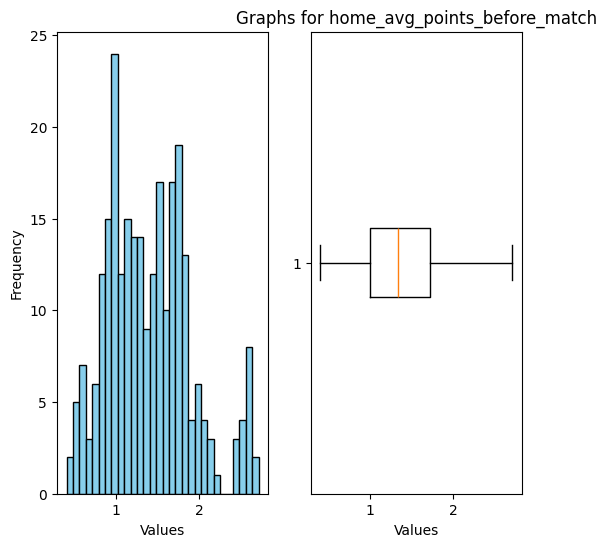

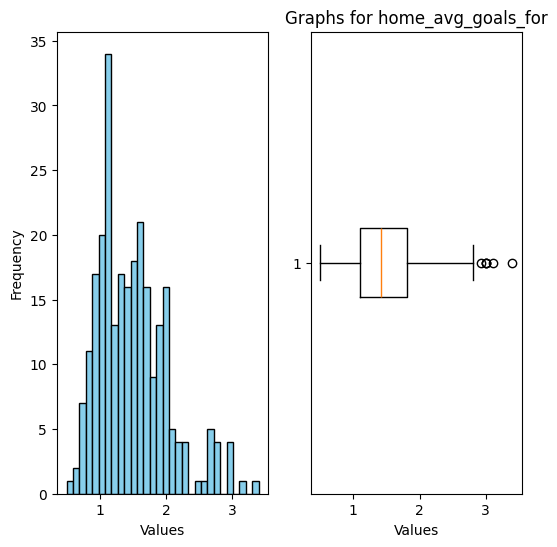

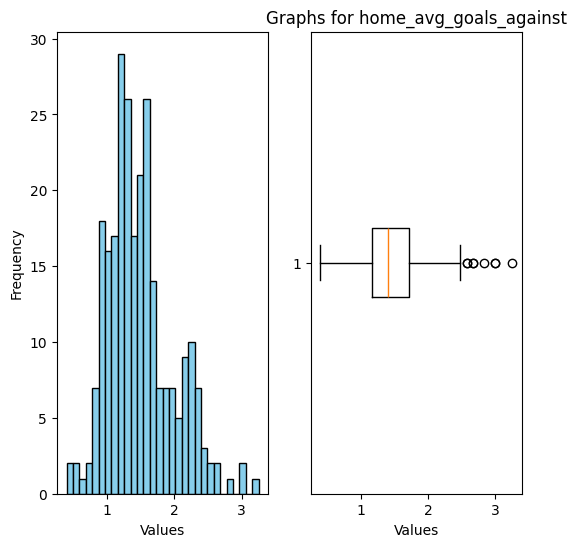

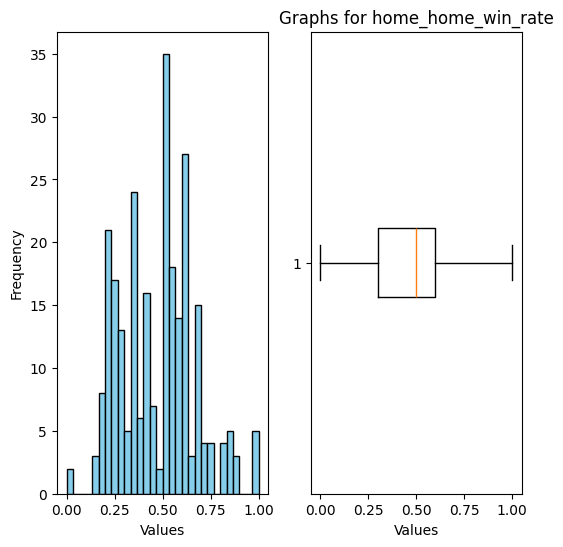

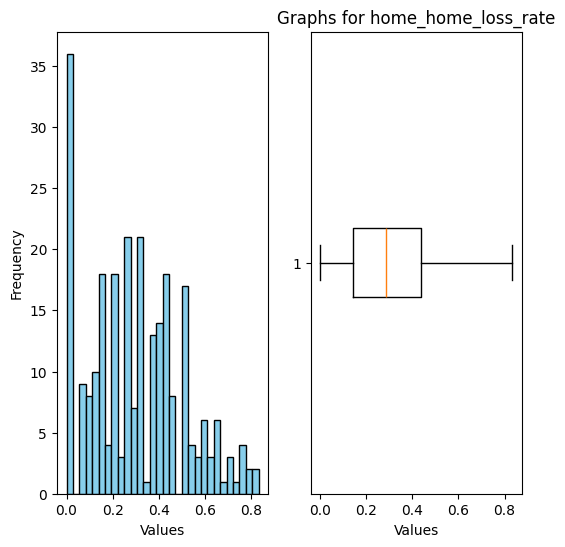

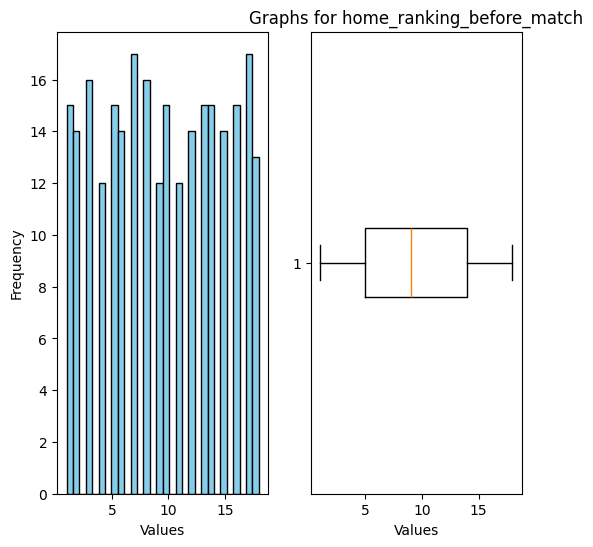

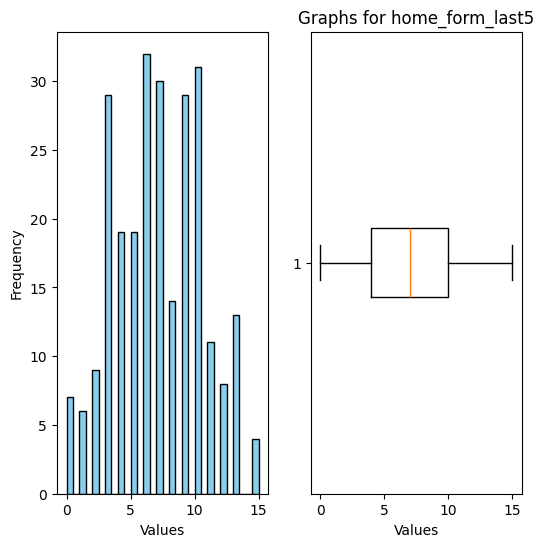

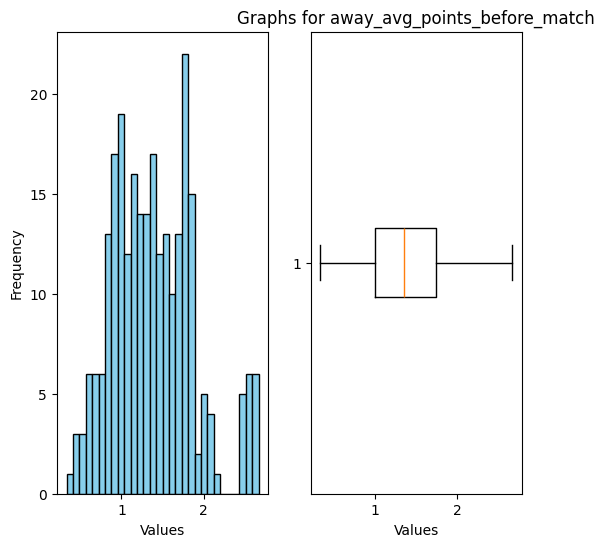

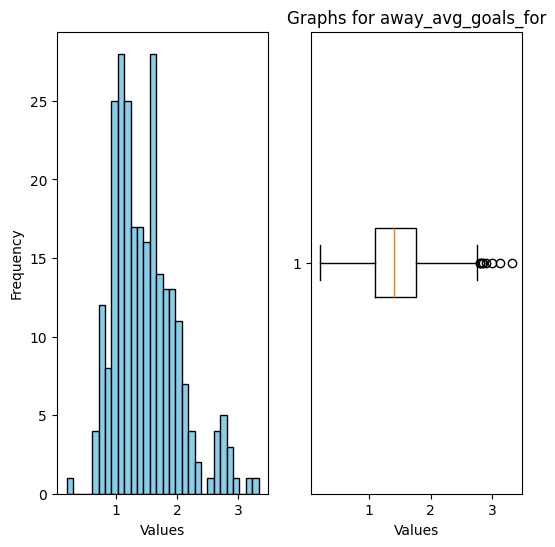

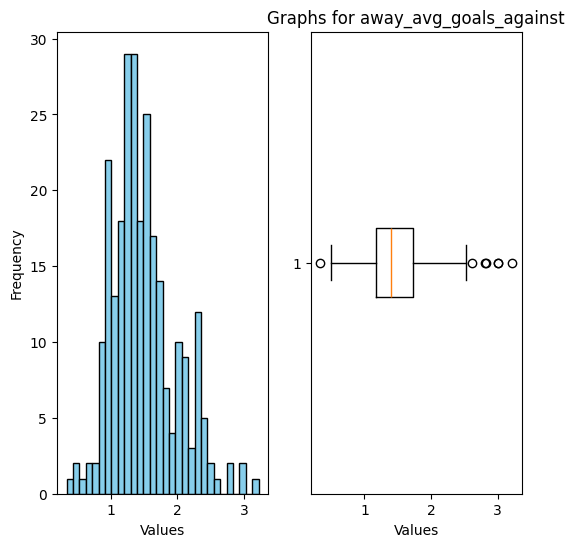

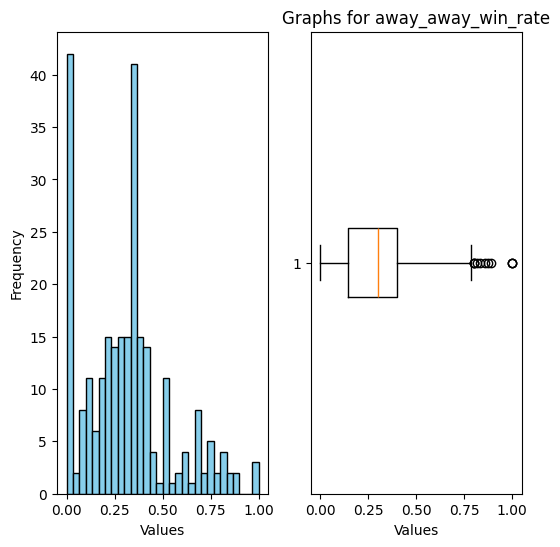

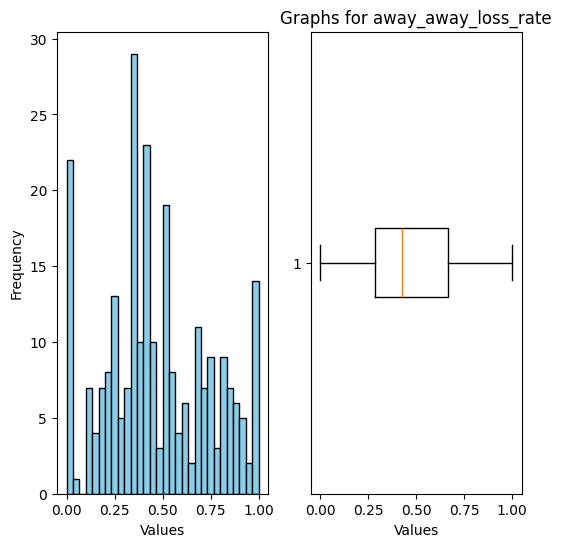

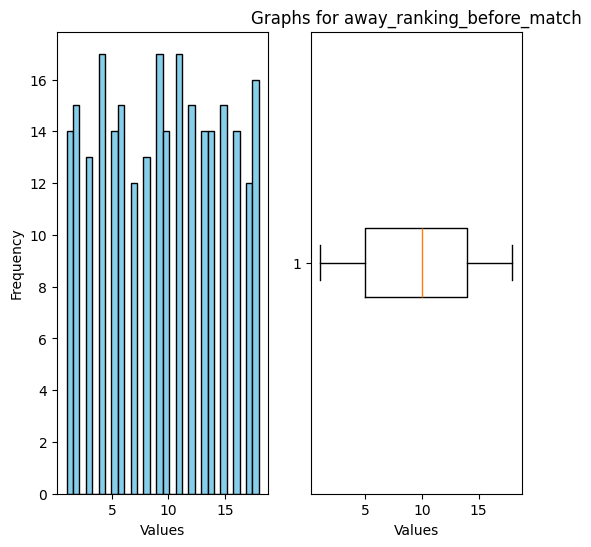

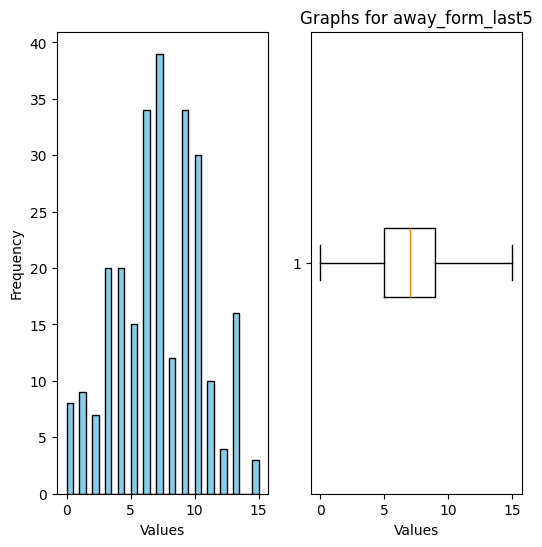

In [132]:
#variable=['home_avg_points_before_match', 'home_avg_goals_for']

for var in variable:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    axs[0].hist(df_for_training[var],bins=30, color='skyblue', edgecolor='black')
    # Adding labels and title
    axs[0].set_xlabel('Values')
    axs[0].set_ylabel('Frequency')
    #axs[0].set_title(f'Basic Histogram of {var}')


    axs[1].boxplot(df_for_training[var],vert=False)
    axs[1].set_xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()


## 3 Analyse des corrélations

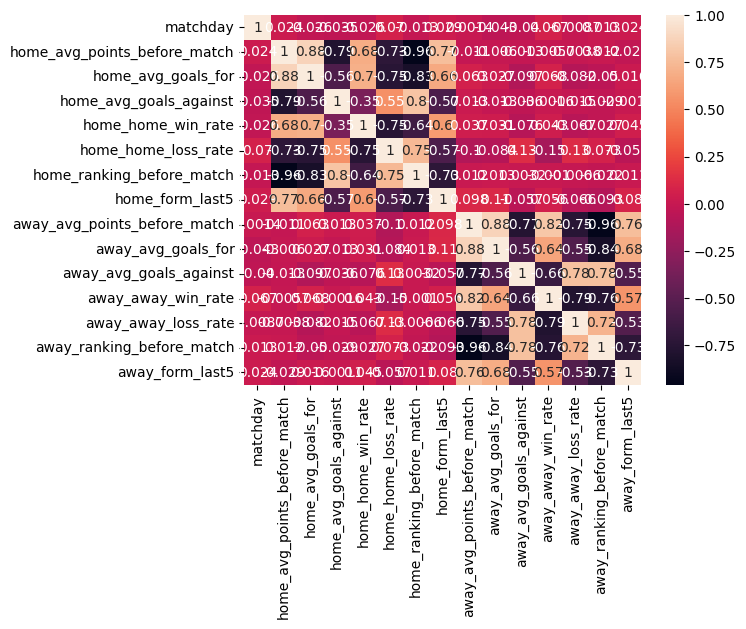

In [93]:
import seaborn as sns

corr=df_for_training.corr(numeric_only=True)

#plotting the heatmap for correlation
ax = sns.heatmap(corr, annot=True)


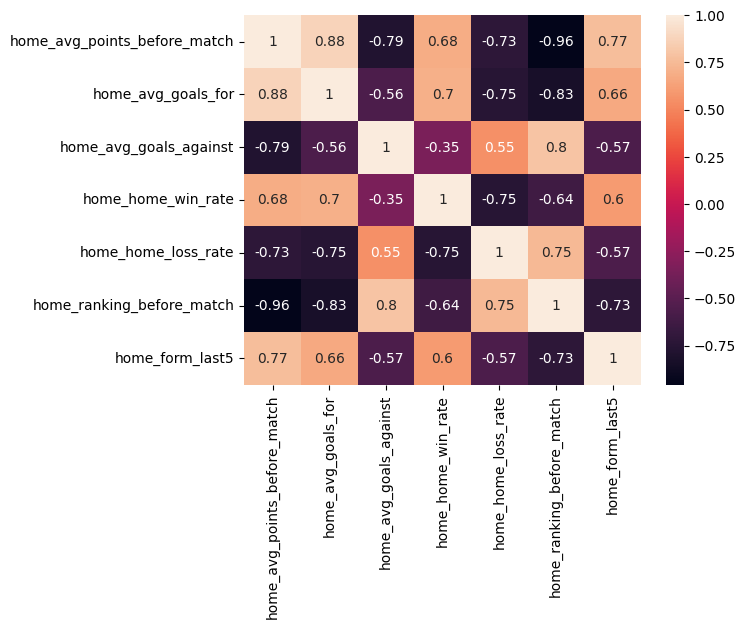

In [94]:
ax = sns.heatmap(corr.iloc[1:8,1:8], annot=True)


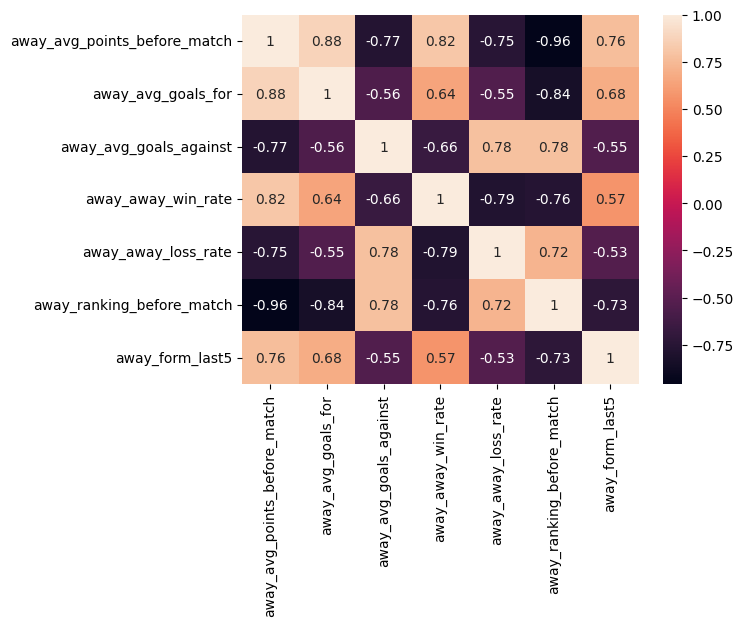

In [95]:

ax = sns.heatmap(corr.iloc[8:16,8:16], annot=True)


There are a few things of note: first, the average point of a team before the match and the ranking before the match are too closely related to both be included in the final model, one of them will need to be excluded. Since the ranking are in a larger scaler than the rest, and also since we might include both seasons with 18 and 20 teams, it seems that the rankings will be excluded.

## 4 Relation entre variable et cible

In [96]:
variable=['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_form_last5']


 Variable : home_avg_points_before_match
    → F = 10.7104
    → p-value = 0.000034


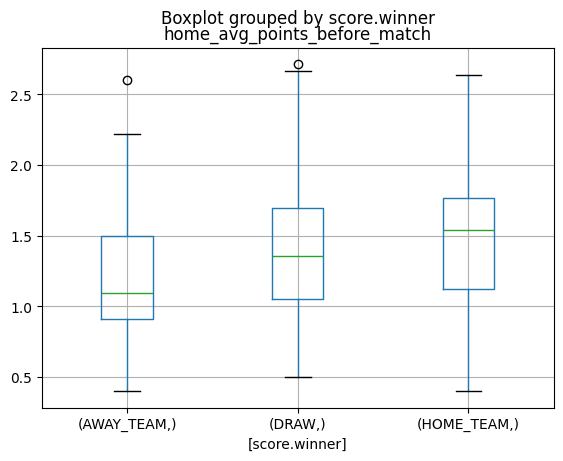


 Variable : home_avg_goals_for
    → F = 15.6176
    → p-value = 0.000000


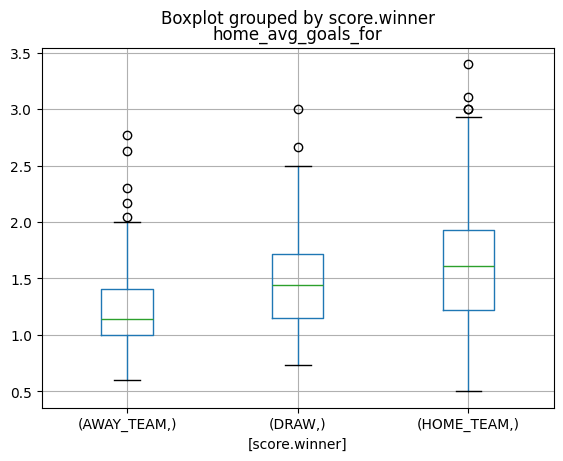


 Variable : home_avg_goals_against
    → F = 4.1835
    → p-value = 0.016292


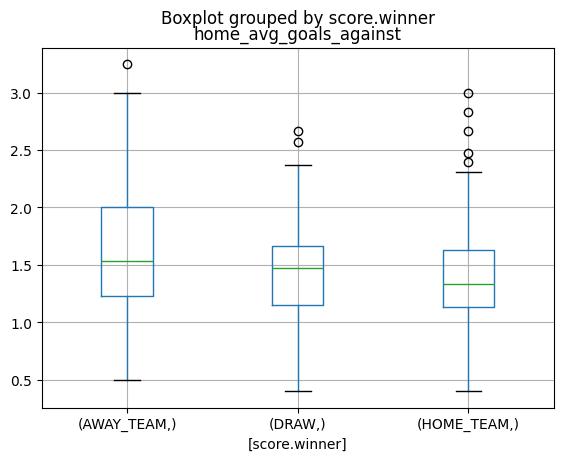


 Variable : home_home_win_rate
    → F = 11.2649
    → p-value = 0.000020


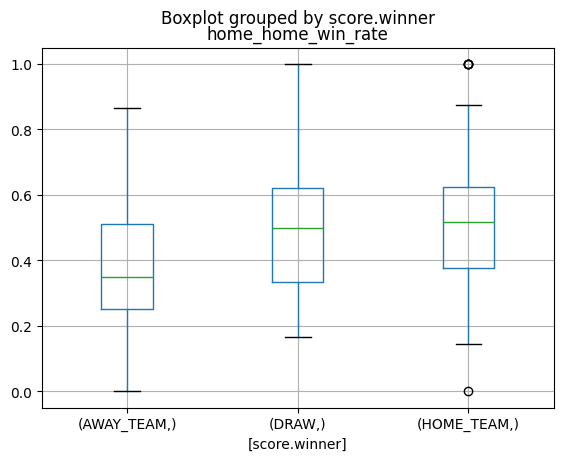


 Variable : home_home_loss_rate
    → F = 9.7140
    → p-value = 0.000086


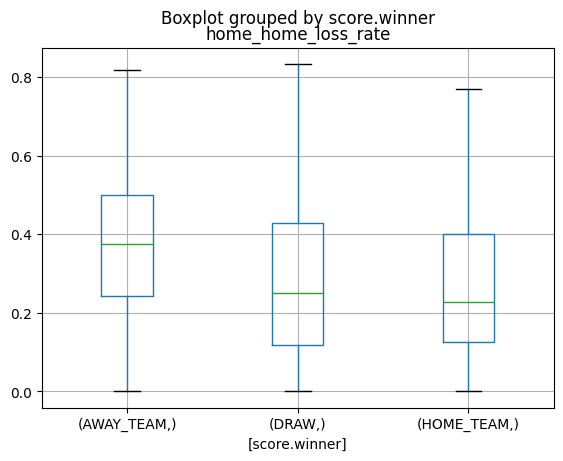


 Variable : home_form_last5
    → F = 3.4674
    → p-value = 0.032659


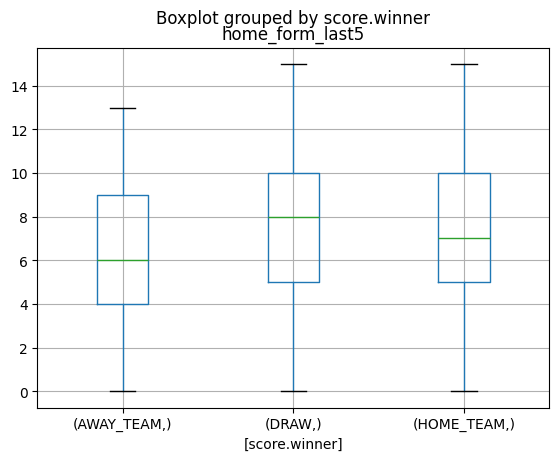


 Variable : away_avg_points_before_match
    → F = 5.3242
    → p-value = 0.005422


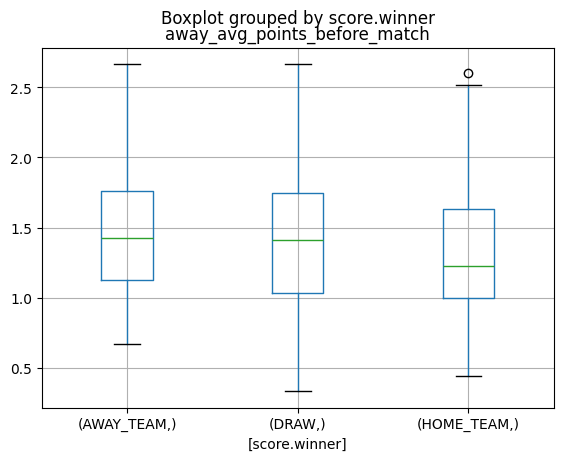


 Variable : away_avg_goals_for
    → F = 4.6790
    → p-value = 0.010090


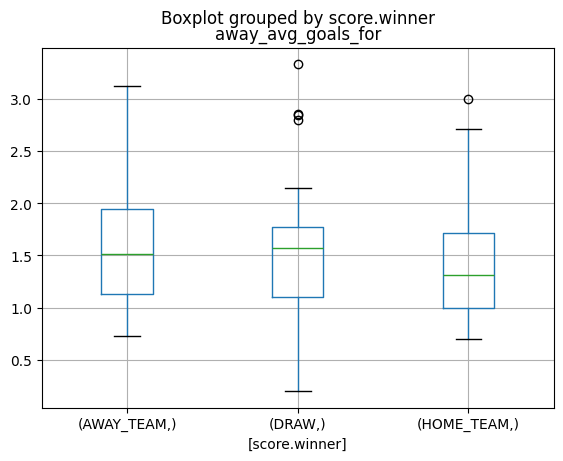


 Variable : away_avg_goals_against
    → F = 7.1206
    → p-value = 0.000977


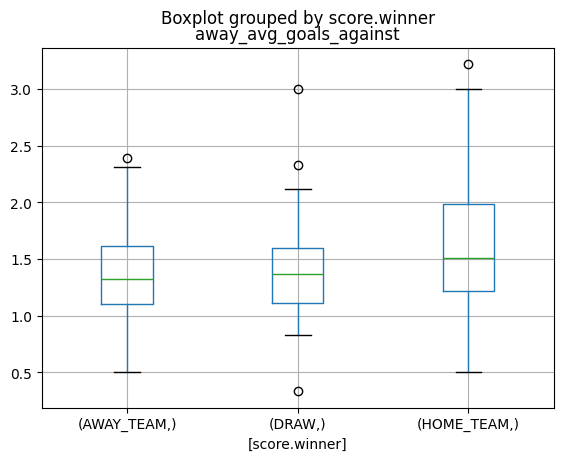


 Variable : away_away_win_rate
    → F = 4.1178
    → p-value = 0.017363


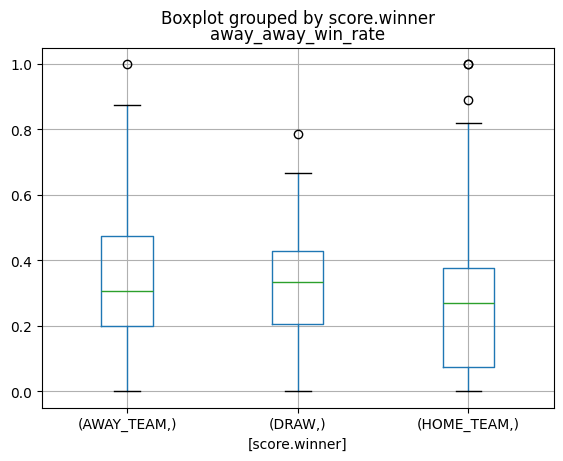


 Variable : away_away_loss_rate
    → F = 6.1740
    → p-value = 0.002403


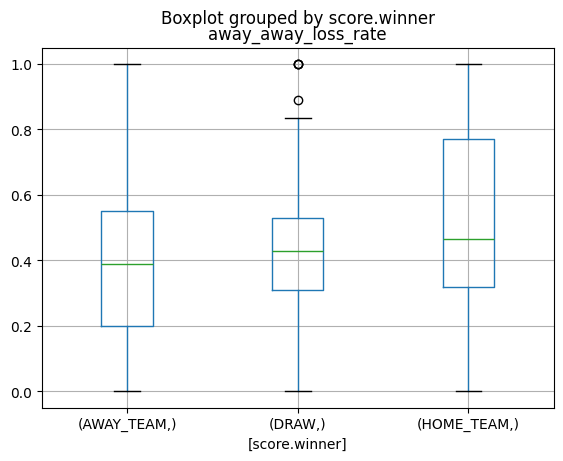


 Variable : away_form_last5
    → F = 2.7013
    → p-value = 0.069015


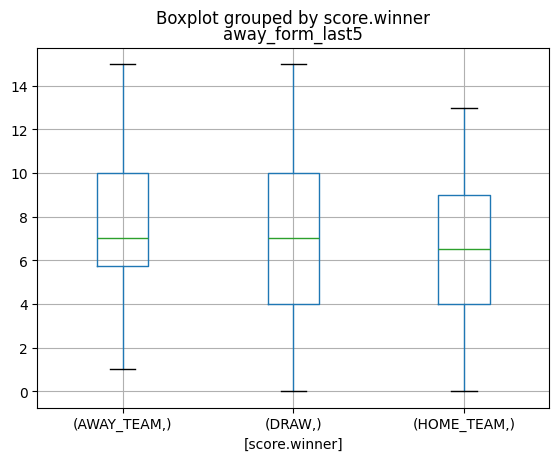

In [97]:
from scipy.stats import f_oneway

classes = ["HOME_TEAM", "AWAY_TEAM", "DRAW"]

for var in variable:
    groups = [df_for_training[df_for_training["score.winner"] == c][var].dropna()
              for c in classes]

    f_stat, p_val = f_oneway(*groups)

    print(f"\n Variable : {var}")
    print(f"    → F = {f_stat:.4f}")
    print(f"    → p-value = {p_val:.6f}")
    df_for_training.boxplot(column=[var],by=['score.winner'])
    #plt.xlabel('Values')
    #axs[1].set_title(f'Basic Histogram of {var}')
    #plt.title(f"Graphs for {var}")
    # Display the plot
    plt.show()

All variables seems strongly related to the cible.

## 5 Analyse temporelle

Vérifier la stabilité des variables notamment en début de saison (on exclut les 5 premiers matchs mais est-ce suffisant)
On a déjà vu quand on a tracé les corrélations que le matchday était peu corrélé au reste, mais on souhaite le vérifier ici.

In [98]:
df_for_training.columns

Index(['matchday', 'score.winner', 'home_avg_points_before_match',
       'home_avg_goals_for', 'home_avg_goals_against', 'home_home_win_rate',
       'home_home_loss_rate', 'home_ranking_before_match', 'home_form_last5',
       'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_ranking_before_match', 'away_form_last5'],
      dtype='object')


 Variable : home_avg_points_before_match
    → Correlation with mathchday = 0.0245


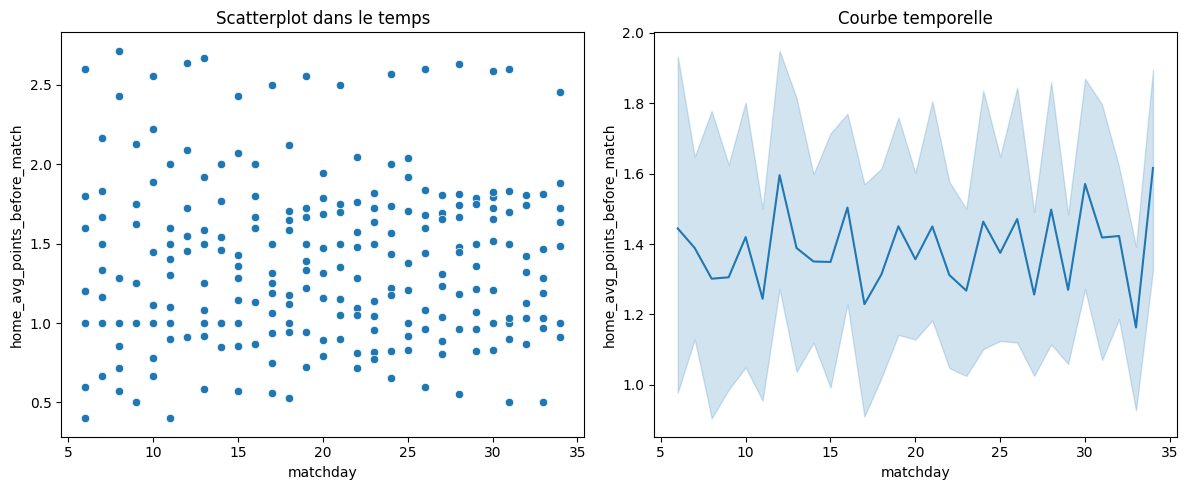


 Variable : home_avg_goals_for
    → Correlation with mathchday = -0.0261


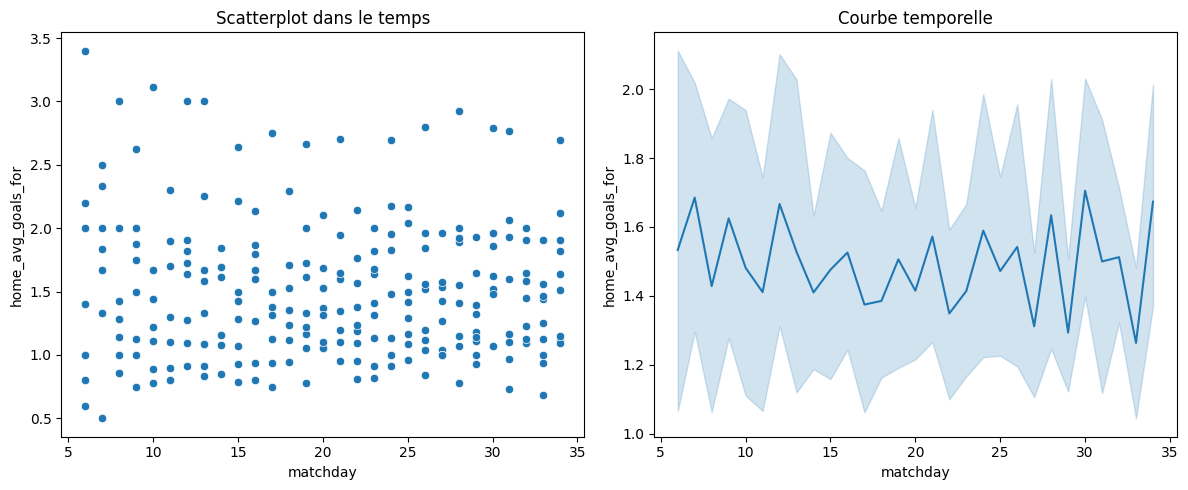


 Variable : home_avg_goals_against
    → Correlation with mathchday = -0.0351


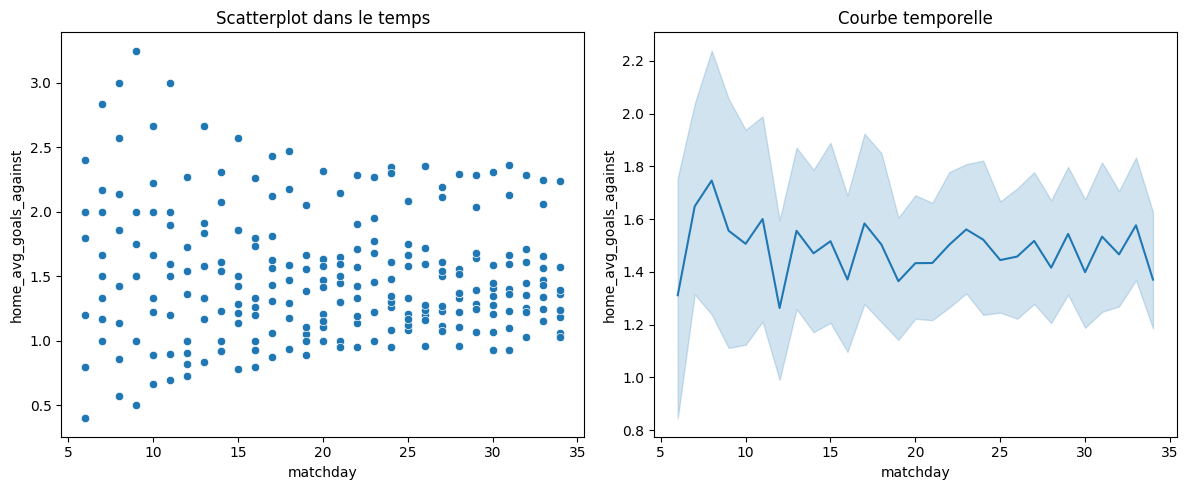


 Variable : home_home_win_rate
    → Correlation with mathchday = -0.0260


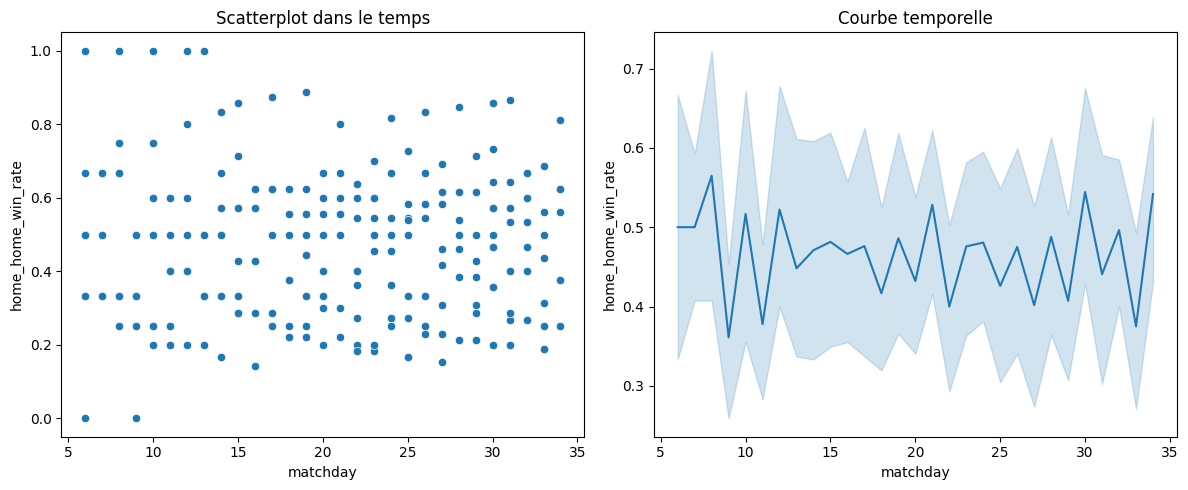


 Variable : home_home_loss_rate
    → Correlation with mathchday = 0.0696


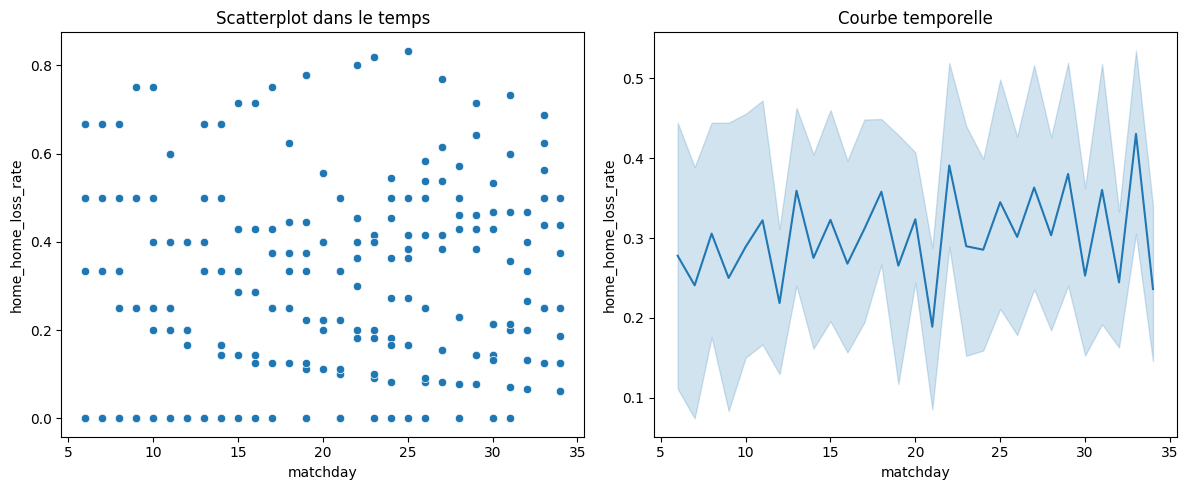


 Variable : home_form_last5
    → Correlation with mathchday = 0.0291


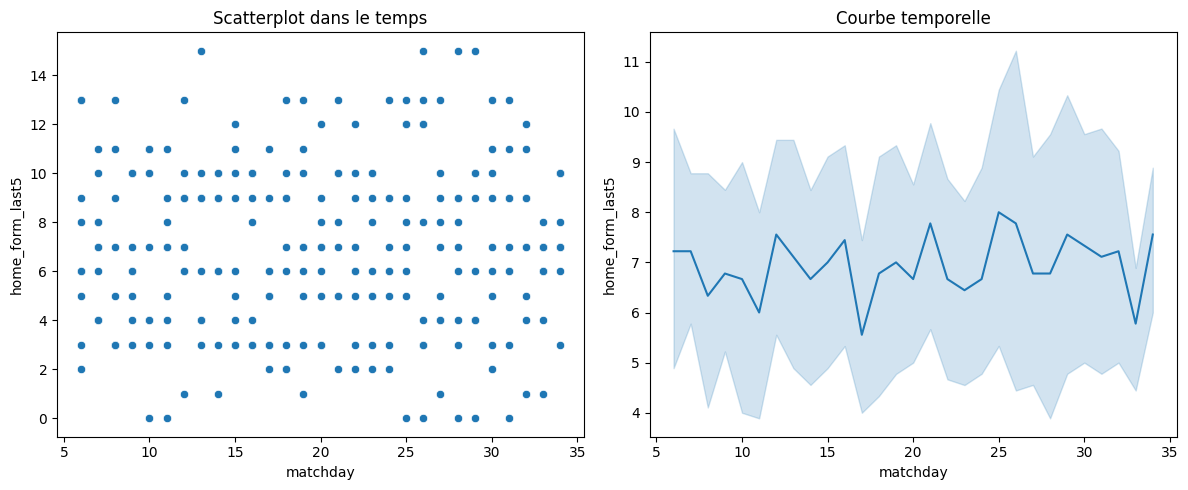


 Variable : away_avg_points_before_match
    → Correlation with mathchday = 0.0014


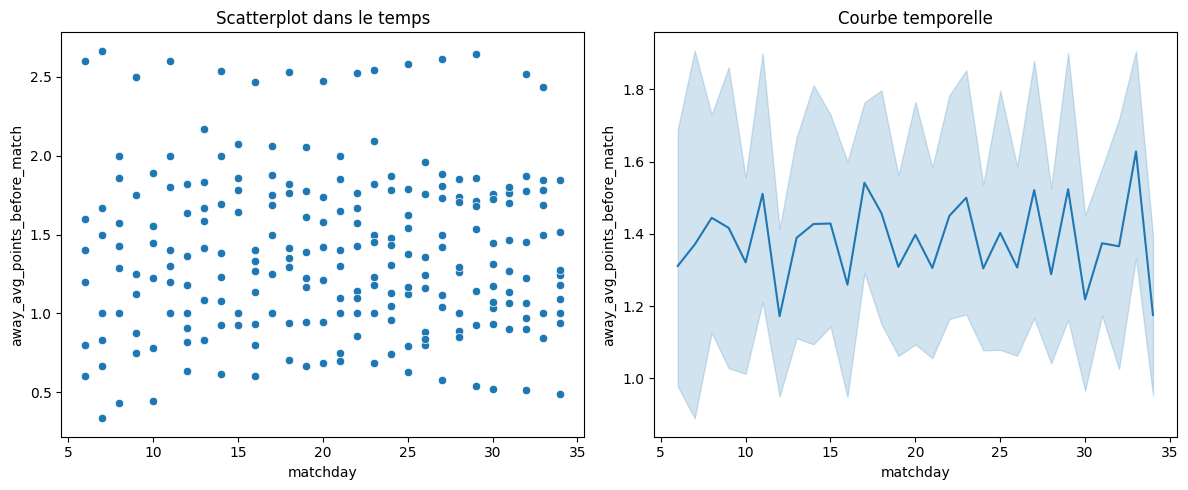


 Variable : away_avg_goals_for
    → Correlation with mathchday = -0.0431


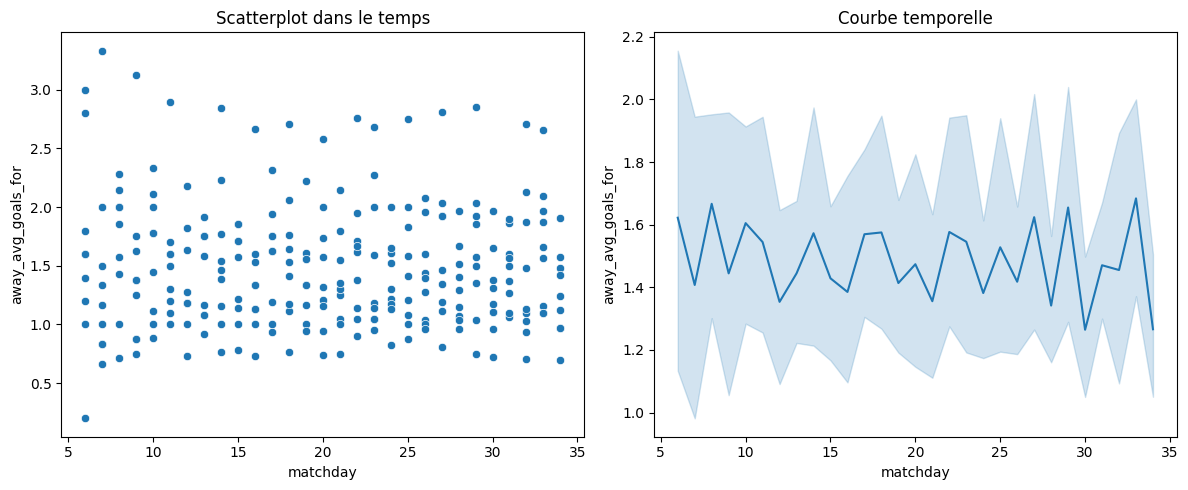


 Variable : away_avg_goals_against
    → Correlation with mathchday = -0.0400


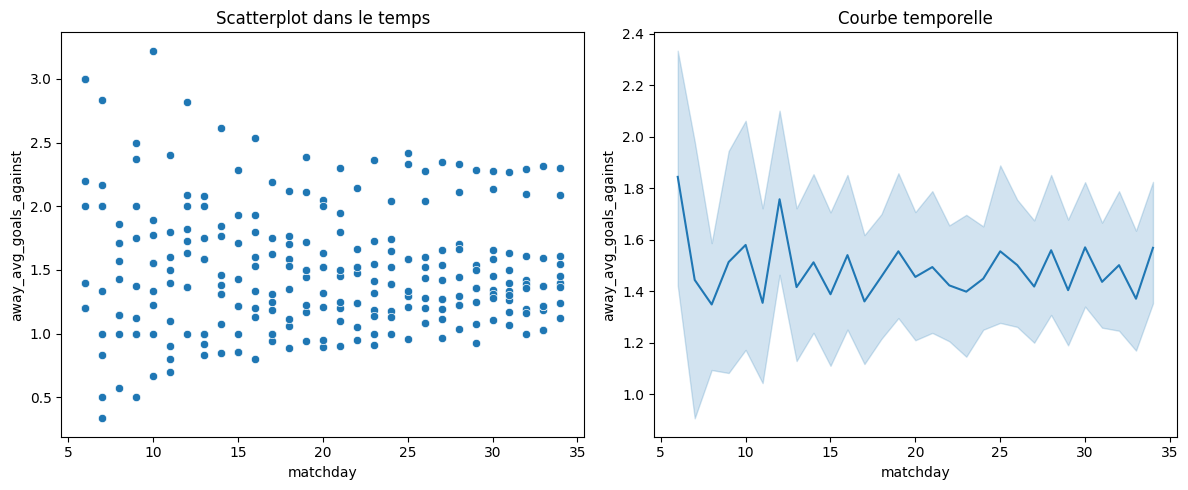


 Variable : away_away_win_rate
    → Correlation with mathchday = 0.0672


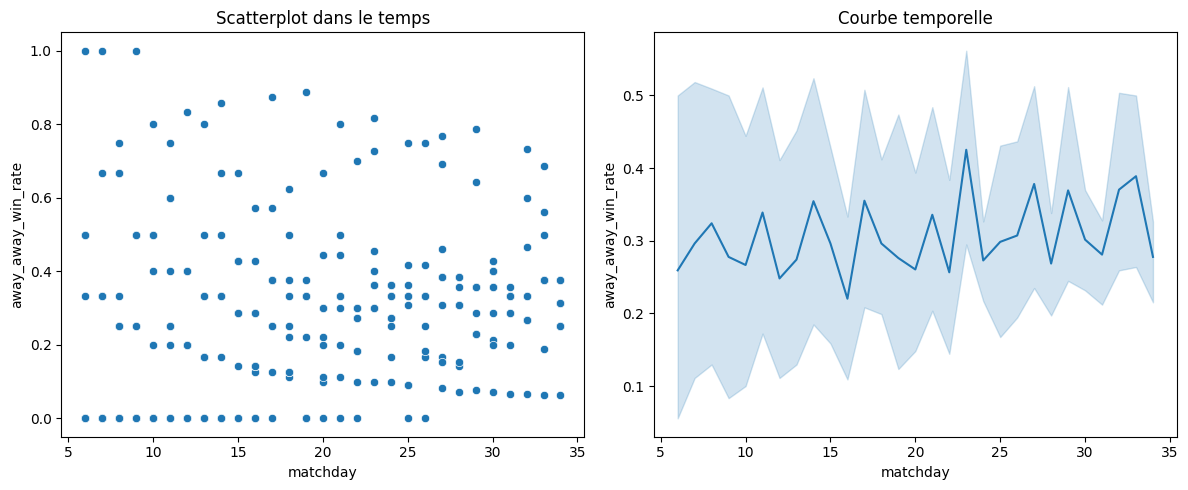


 Variable : away_away_loss_rate
    → Correlation with mathchday = -0.0087


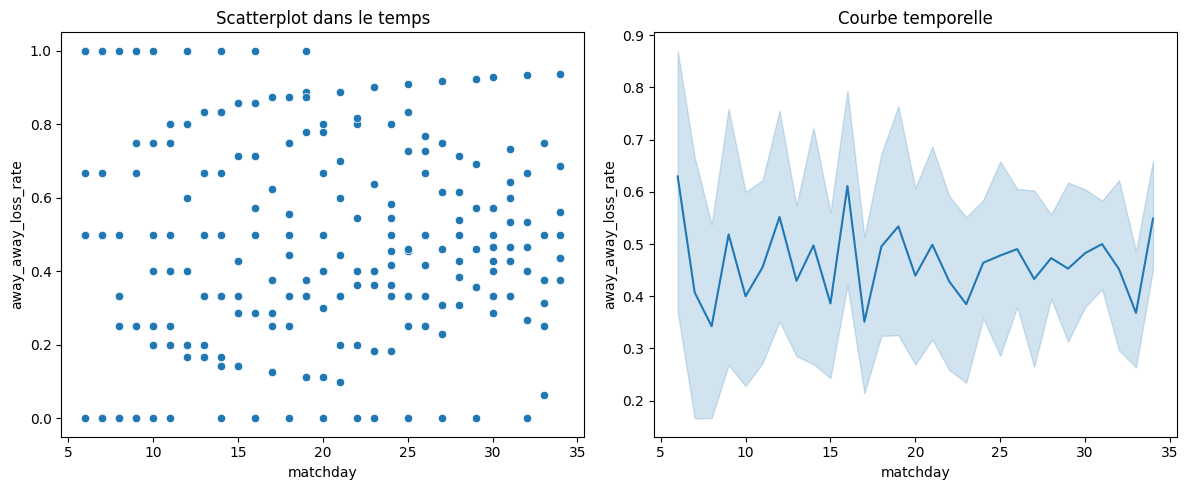


 Variable : away_form_last5
    → Correlation with mathchday = 0.0235


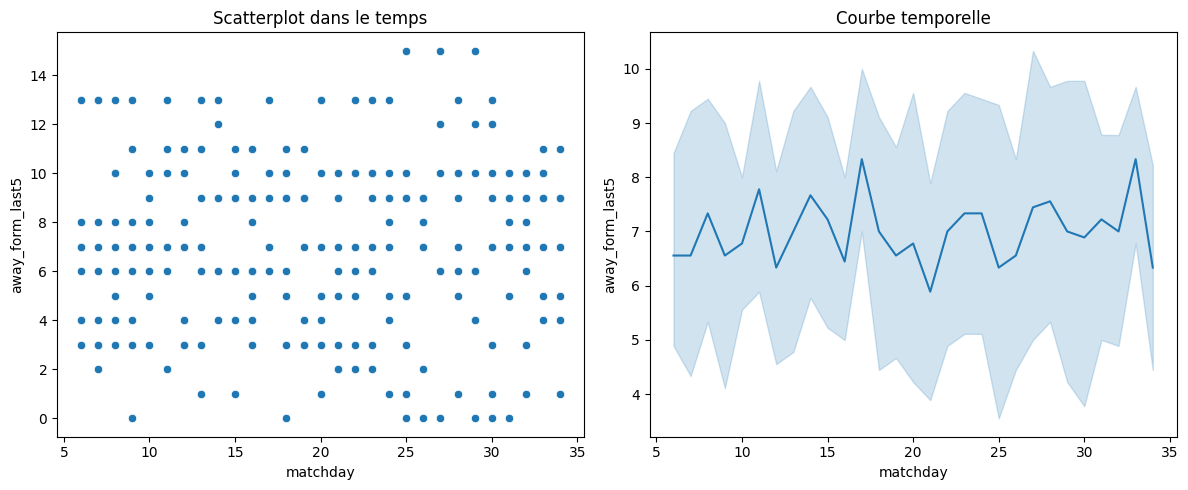

In [99]:
for var in variable:
    corr1=corr.loc["matchday",var]
    print(f"\n Variable : {var}")
    print(f"    → Correlation with mathchday = {corr1:.4f}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graph 1
    sns.scatterplot(
        data=df_for_training,
        x="matchday",
        y=var,
        ax=axs[0]
    )
    axs[0].set_title("Scatterplot dans le temps")

    # Graph 2
    sns.lineplot(
        data=df_for_training,
        x="matchday",
        y=var,
        ax=axs[1]
    )
    axs[1].set_title("Courbe temporelle")

    plt.tight_layout()
    plt.show()



# Preparation à la modélisation

objectif: finir de nettoyer data_for_training et séparer en X/Y, et préparer pour validation (valider sur la saison 2025-2026 en excluant les 5 premiers matchs comme sur la base d'entrainement)
-ajouter plus de saisons

In [126]:
matches_2023=load_raw_matches("../data/raw/",season_id=2023)
#matches_2023=fetch_matches(2015,season_id=2023)
#save_raw_matches(matches_2023,"../data/raw/")
df_matches_2023 = pd.json_normalize(matches_2023["matches"])
df_train_2023=prepa_donnee(df_matches_2023[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]])


In [137]:
print(df_for_training.shape)
print(df_train_2023.shape)

df_training = pd.concat([df_for_training, df_train_2023], ignore_index=True)
print(df_training.shape)


(261, 16)
(261, 16)
(522, 16)


X should not include the columns 'matchday', 'score.winner', 'home_ranking_before_match' and 'away_ranking_before_match' while Y should be score.winner.

In [138]:
X_train=df_training.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match"])
y_train=df_training["score.winner"]

Now we will get the validation dataset

In [102]:
matches_2025=load_raw_matches("../data/raw/",season_id=2025)
df_matches_2025 = pd.json_normalize(matches_2025["matches"])

df_for_validation=prepa_donnee(df_matches_2025[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]])

In [103]:
df_for_validation=df_for_validation[df_for_validation.matchday<=13]

In [104]:
X_valid=df_for_validation.drop(columns=["matchday","score.winner","home_ranking_before_match","away_ranking_before_match"],inplace=False)
y_valid=df_for_validation["score.winner"]

## Pipelines

In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    log_loss, brier_score_loss, accuracy_score, confusion_matrix
)
from sklearn.calibration import calibration_curve

In [106]:
num_features = ['home_avg_points_before_match', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_home_win_rate', 'home_home_loss_rate',
       'home_form_last5', 'away_avg_points_before_match', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_away_win_rate', 'away_away_loss_rate',
       'away_form_last5']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)
    ]
)

# Modélisation

## Finir les pipelines

In [154]:
pipelines={
    'logreg': make_pipeline(preprocessor,LogisticRegression(max_iter=1000,solver='lbfgs')),
    'forest':make_pipeline(preprocessor,RandomForestClassifier()),
    'gboost':make_pipeline(preprocessor,GradientBoostingClassifier())
}

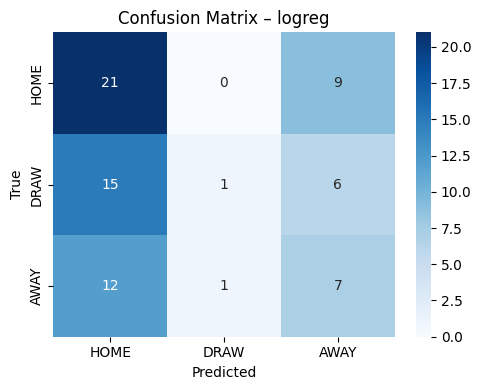

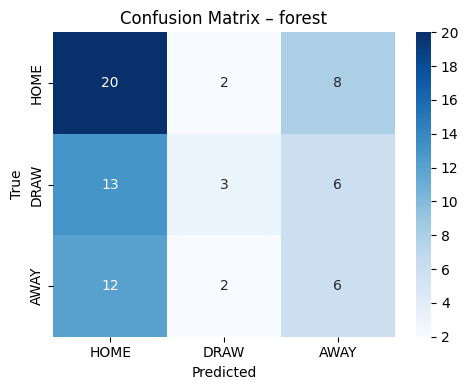

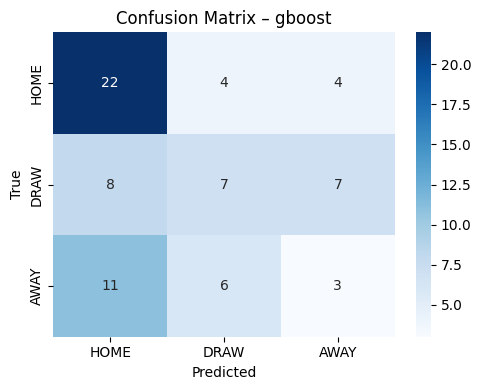

,model,accuracy,log_loss,brier_score
1,forest,0.402778,1.102490,0.220640
0,logreg,0.402778,1.116151,0.224535
2,gboost,0.444444,1.176063,0.235632


In [155]:
results=[]

for name, model in pipelines.items():
    
    # ---- Train ----
    model.fit(X_train, y_train)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    results.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(results)
display(df_results.sort_values("log_loss"))

## Essai avec des pipelines calibrées

In [156]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_pipelines = {}
for name, pipe in pipelines.items():
    calibrated_pipelines[name] = CalibratedClassifierCV(pipe, cv=5, method='isotonic')

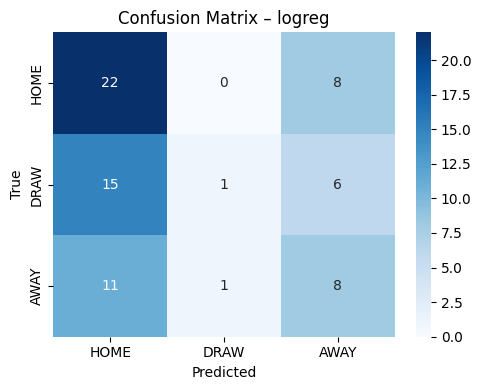

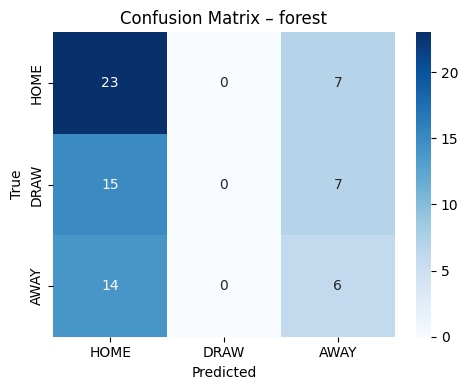

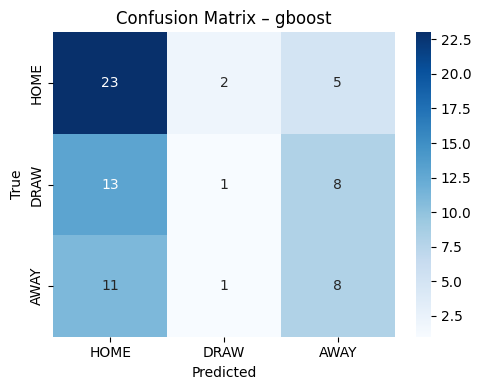

,model,accuracy,log_loss,brier_score
1,forest,0.402778,1.071413,0.215132
2,gboost,0.444444,1.105648,0.218815
0,logreg,0.430556,1.121942,0.224186


In [157]:
cal_results=[]

for name, model in calibrated_pipelines.items():
    
    # ---- Train ----
    model.fit(X_train, y_train)
    
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    cal_results.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



# ---- Summary table ----
df_results = pd.DataFrame(cal_results)
display(df_results.sort_values("log_loss"))

## Hyperparameter fine tuning

In [145]:
from sklearn.model_selection import GridSearchCV


In [163]:
lr_params={
    'logisticregression__C':[0.01,0.1,1,10],
    'logisticregression__penalty':['l2'],
    'logisticregression__solver':  ['lbfgs']
}

rf_params = {
    'randomforestclassifier__n_estimators': [200, 500],
    'randomforestclassifier__max_depth': [None, 10],
    'randomforestclassifier__min_samples_leaf': [1, 4]
}

gb_params = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05,0.1],
    'gradientboostingclassifier__max_depth': [3, 5],
}

params={
    'logreg':lr_params,
    'forest':rf_params,
    'gboost':gb_params
}




In [164]:
fitted_models={}
for name, estimator in pipelines.items():
    print("fitting model:",name)
    model=GridSearchCV(estimator,
                       param_grid=params[name],
                       cv=3,scoring='neg_log_loss')
    model.fit(X_train,y_train)
    fitted_models[name]=model

fitting model: logreg
fitting model: forest
fitting model: gboost


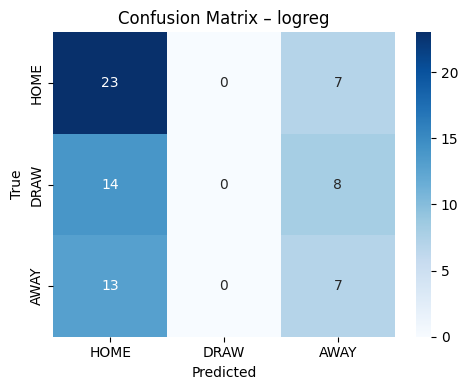

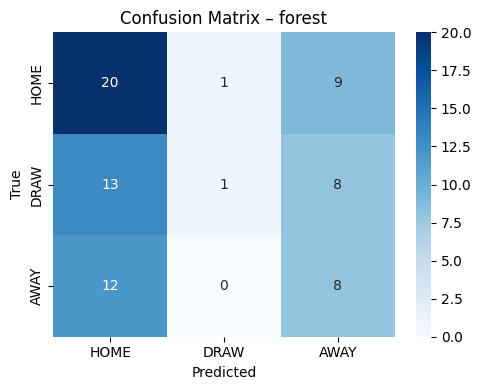

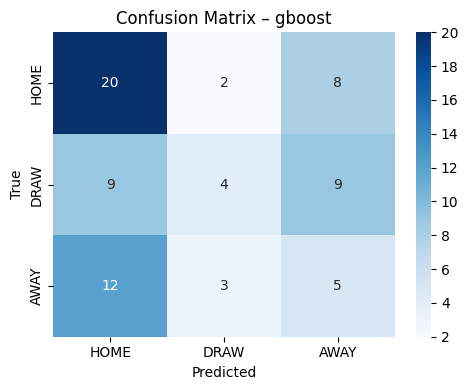

,model,accuracy,log_loss,brier_score
1,forest,0.402778,1.078578,0.217466
2,gboost,0.402778,1.099902,0.221820
0,logreg,0.416667,1.105060,0.222668


In [166]:
result_grid=[]
for name, model in fitted_models.items():
    # ---- Predict ----
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(model.classes_)
    ])
    
    result_grid.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(result_grid)
display(df_results.sort_values("log_loss"))

### Calibré et random searché

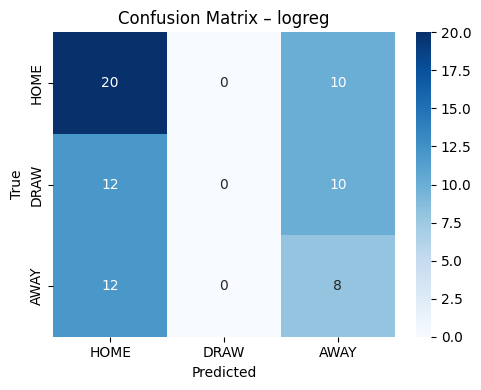

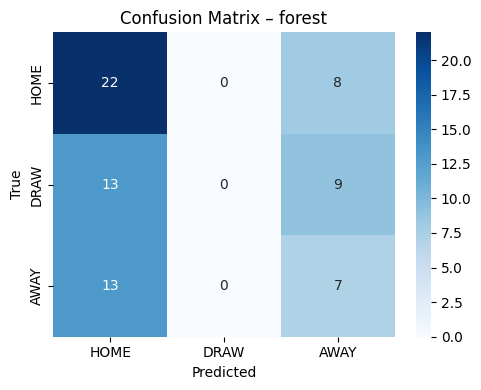

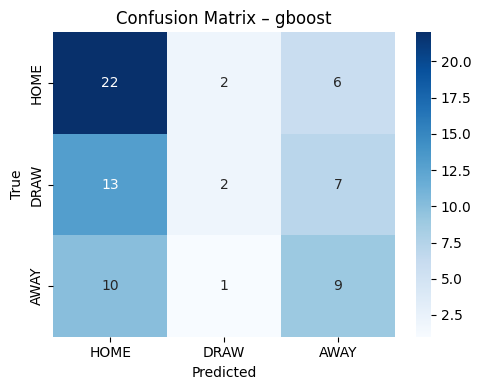

,model,accuracy,log_loss,brier_score
1,forest,0.402778,1.068116,0.215056
2,gboost,0.458333,1.078869,0.213878
0,logreg,0.388889,1.607796,0.229562


In [168]:
result_grid=[]
for name, model in fitted_models.items():
    # ---- Predict ----
    calibrated = CalibratedClassifierCV(model.best_estimator_, cv=5, method='isotonic')
    calibrated.fit(X_train, y_train)

    y_pred = calibrated.predict(X_valid)
    y_proba = calibrated.predict_proba(X_valid)

    # ---- Metrics ----
    acc = accuracy_score(y_valid, y_pred)
    ll  = log_loss(y_valid, y_proba)
    
    # Brier multi-classe = moyenne des Brier par classe
    brier = np.mean([
        brier_score_loss((y_valid == c).astype(int), y_proba[:, idx])
        for idx, c in enumerate(calibrated.classes_)
    ])
    
    result_grid.append({
        "model": name,
        "accuracy": acc,
        "log_loss": ll,
        "brier_score": brier
    })
    
    cm = confusion_matrix(y_valid, y_pred, labels=["HOME_TEAM", "DRAW", "AWAY_TEAM"])

    plt.figure(figsize=(5,4))  # ← nouvelle figure à chaque boucle
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["HOME", "DRAW", "AWAY"],
                yticklabels=["HOME", "DRAW", "AWAY"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame(result_grid)
display(df_results.sort_values("log_loss"))

# juste pour moi

In [ ]:
df_matches_2025 = pd.json_normalize(matches_2025["matches"])


In [175]:

df_for_validation=prepa_donnee(df_matches_2025[["status","matchday","homeTeam.id","homeTeam.name","awayTeam.id","awayTeam.name",
                       "score.winner","score.fullTime.home","score.fullTime.away"]])

In [181]:
for_fun=df_for_validation[df_for_validation.matchday==15]
for_fun2=for_fun[for_fun["homeTeam.name"]=="Paris Saint-Germain FC"]

X_for_fun=for_fun2.drop(columns=["matchday","homeTeam.name","score.winner","home_ranking_before_match","away_ranking_before_match"],inplace=False)

In [186]:
for name, model in fitted_models.items():
    calibrated = CalibratedClassifierCV(model.best_estimator_, cv=5, method='isotonic')
    calibrated.fit(X_train,y_train)

    y_proba = calibrated.predict_proba(X_for_fun)
    labels = calibrated.classes_  # ['AWAY_TEAM', 'DRAW', 'HOME_TEAM'] par ex.
    
    # Afficher sous forme de DataFrame pour plus de clarté
    df_proba = pd.DataFrame(y_proba, columns=labels)
    
    print(f"Model: {name}")
    print(df_proba)
    print("\n")


Model: logreg
   AWAY_TEAM      DRAW  HOME_TEAM
0   0.126123  0.230748   0.643129


Model: forest
   AWAY_TEAM      DRAW  HOME_TEAM
0   0.185683  0.250332   0.563985


Model: gboost
   AWAY_TEAM      DRAW  HOME_TEAM
0   0.243764  0.233239   0.522997


